# SVM con *scorings*
Prueba de SVM con los scorings calculados con:
- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings
warnings.filterwarnings('ignore')

Carga del DataFrame Principal:

In [2]:
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
df_cdk2_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919


Carga de los dataframes con los mejores scores de las proteínas para cada programa de *docking*.

In [4]:
# Vinardo scoring 16x
df_vinardo_results = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

In [271]:
# Carga de los datos DUD
# Split de los sets de entrenamiento y prueba
df_vrd_DUD2006 = pd.read_csv(F'./B_DATOS/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
y_DUD = pd.Series(df_vrd_DUD2006.Actividad == "Active", dtype = int)
X_DUD = df_vrd_DUD2006.drop(["Actividad"], axis = 1)

print("Dims X_DUD", X_DUD.shape)

Dims X_DUD (2146, 402)


In [100]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7, 7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label = ''):
    # inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
    auc = roc_auc_score( y_true = true_values, y_score = predicted_values)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label = '', titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

# SVM Lineal con Vinardo 16x
## Dataset Completo

In [266]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [289]:
def run_CV(X_train, y_train):    
    # Se establece el pipeline para el gridSearch
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()),
            ("SVC", SVC(kernel='linear', probability = True))
        ])

    parametros = {'SVC__C': [10**i for i in range(-3, 4)]}
    linear_SVC = GridSearchCV(SVCpipe, parametros, 
                             scoring = 'roc_auc',
                             cv = 5, return_train_score = True)

    # Entrenamiento con el grid
    linear_SVC.fit(X_train, y_train)
    
    # Retorna el mejor modelo
    return(linear_SVC.best_estimator_)

In [224]:
filtro = df_vinardo_results.columns
df = df_vinardo_results[ filtro ]
X = df.drop(["ActiveInactive"], axis = 1)
y = (df["ActiveInactive"] == "Active").astype(np.float32)

print(F'Dimensiones de X: {X.shape}')
print(F'Dimensiones de y: {y.shape}')

# Split del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

Dimensiones de X: (111, 402)
Dimensiones de y: (111,)


In [225]:
svc_1 = run_SVM(X_train, y_train)

In [226]:
svc_1.score(X_train, y_train)

1.0

In [227]:
svc_1.score(X_test, y_test)

0.9565217391304348

In [228]:
svc_1.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0.], dtype=float32)

In [229]:
y_score = svc_1.decision_function(X_test)
y_score

array([-1.54618711, -1.08269584, -1.39574516, -1.06302291, -1.07419751,
       -0.99037922, -1.23362861,  1.32038029, -1.2541012 , -1.45413776,
       -0.9438115 ,  0.71850265, -0.90011185, -0.14535717, -0.52724259,
       -1.39881169,  1.07361179,  0.13471664, -0.96193687, -0.91687901,
       -1.57142368, -1.19606174, -1.29813874])

In [230]:
roc_auc_score( y_true = y_test, y_score = svc_1.decision_function(X_test)) 

1.0

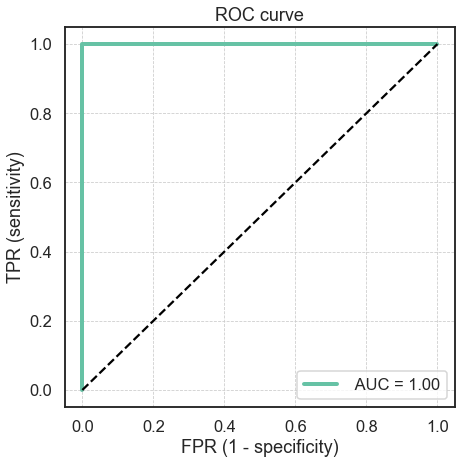

In [231]:
plot_roc(y_score, y_test, titulo = "ROC curve")

In [232]:
# Prueba del modelo con los DUD
svc_1.score(X_DUD, y_DUD)

0.929636533084809

In [233]:
# Prueba AUC
y_dud_score = svc_1.decision_function(X_DUD)
y_dud_score

array([ 0.7748632 , -0.51856976, -0.17909053, ..., -0.66184445,
       -1.6141995 , -0.1865491 ])

In [234]:
roc_auc_score( y_true = y_DUD, y_score = y_dud_score) 

0.791231383263688

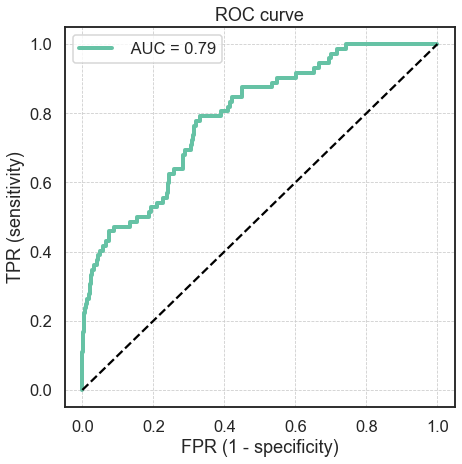

In [235]:
plot_roc(y_dud_score, y_DUD, titulo = "ROC curve")

In [216]:
# Se reentrena el modelo con todos los datos del primer set
svc_1.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='linear', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [217]:
svc_1.score(X_DUD, y_DUD)

0.9137931034482759

In [218]:
y_dud_score = svc_1.decision_function(X_DUD)
roc_auc_score( y_true = y_DUD, y_score = y_dud_score) 

0.7849766955962714

In [160]:
# Prueba con las conformaciones del frente de pareto 5 objetivos
pf_5_obj = ['1ckp', '1h07', '1ke9', '1oiq', '1pxm', '1urw', '1vyz', '2c4g', '2r3p',
       '2r64', '2vv9', '2w05', '3eid', '3ezv', '3lfn', '3qu0', '3s0o', '3s2p',
       '3unj', '3unk', '4bzd', '4cfn', '4eor', '4fkq', '6guf']

In [316]:
def run_SVM(X_train, X_test, y_train, y_test):
    # Determina el mejor modelo usando grid search y validación cruzada
    #best_clasifier = run_CV(X_train, y_train)
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
            ("SVC", SVC(kernel='linear', probability = True))
        ])

    parametros = {'SVC__C': [10**i for i in range(-3, 4)]}
    linear_SVC = GridSearchCV(SVCpipe, parametros, 
                             scoring = 'roc_auc',
                             cv = 5, return_train_score = True)
    # Entrenamiento con el grid
    linear_SVC.fit(X_train, y_train)
    
    # Retorna el mejor modelo
    best_clasifier = linear_SVC.best_estimator_
    # Realiza la estandarización sobre el X_test
    X_test = StandardScaler().fit_transform(X_test)
    
    # Predicciones sobre X_test
    y_pred = best_clasifier.predict(X_test) # Valores predichos
    y_score = best_clasifier.decision_function(X_test) # Distancia al hiperplano
    y_prob = best_clasifier.predict_proba(X_test)
    # Genera algunos outputs
    print("Accuracy:", metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    print("Precision:",metrics.precision_score(y_true = y_test, y_pred = y_pred))
    print("Recall:",metrics.recall_score(y_true = y_test, y_pred = y_pred))
    # Matirz de confusión
    print('Matriz de confusión:\n', confusion_matrix(y_true = y_test, y_pred = y_pred))
    # AUC
    print("AUC ROC:", roc_auc_score( y_true = y_test, y_score = y_score))
    # Plot del ROC
    plot_roc(y_score, y_test, titulo = "ROC curve")

Accuracy: 0.8392357875116496
Precision: 0.10888252148997135
Recall: 0.5277777777777778
Matriz de confusión:
 [[1763  311]
 [  34   38]]
AUC ROC: 0.8047385620915033


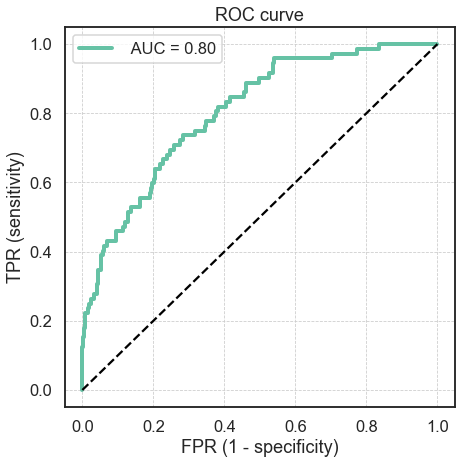

In [317]:
# Usando DUD
X_train = df_vinardo_results.drop(["ActiveInactive"], axis=1)
y_train = (df["ActiveInactive"] == "Active").astype(np.float32)

X_test = X_DUD
y_test = y_DUD

run_SVM(X_train, X_test, y_train, y_test)

In [313]:
X = df_vinardo_results.drop(["ActiveInactive"], axis=1)
y = (df["ActiveInactive"] == "Active").astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

run_SVM(X_train, X_test, y_train, y_test)

Accuracy: 0.9565217391304348
Precision: 0.8333333333333334
Recall: 1.0
Matriz de confusión:
 [[17  1]
 [ 0  5]]
AUC ROC: 1.0


In [294]:
# Usando DUD
X_train = df_vinardo_results.drop(["ActiveInactive"], axis=1)
y_train = (df["ActiveInactive"] == "Active").astype(np.float32)

X_test = X_DUD
y_test = y_DUD

run_SVM(X_train, X_test, y_train, y_test)

Accuracy: 0.9221808014911463
Precision: 0.18543046357615894
Recall: 0.3888888888888889
Matriz de confusión:
 [[1951  123]
 [  44   28]]
AUC ROC: 0.7771817743490839


Dimensiones de X: (111, 402)
Dimensiones de y: (111,)
Dimensiones de X_train: (88, 402)
Dimensiones de y_train: (88,)
Accuracy: 0.9137931034482759
Precision: 0.17341040462427745
Recall: 0.4166666666666667
AUC ROC: 0.7849766955962714


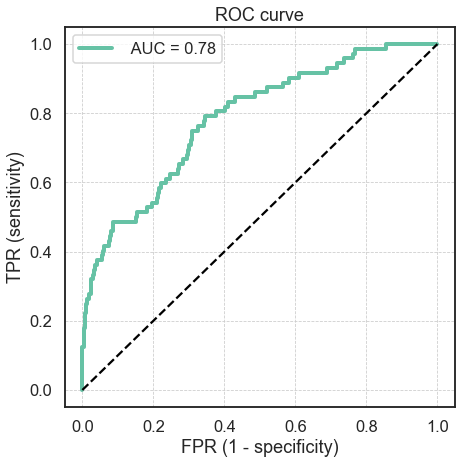

In [259]:
# Primero se define la matriz X y el vector y
X = df_vinardo_results.drop(["ActiveInactive"], axis=1)
y = (df["ActiveInactive"] == "Active").astype(np.float32)
print(F'Dimensiones de X: {X.shape}')
print(F'Dimensiones de y: {y.shape}')

X_DUD = X_DUD

# Depués se realiza el split para obtener los conjuntos de entrenamiento y de validación
# Usamos el parémtro stratify para estable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
print(F'Dimensiones de X_train: {X_train.shape}')
print(F'Dimensiones de y_train: {y_train.shape}')

# Se genera el modelo
best_clasificador = run_SVM(X, y)
# Se obtienen los datos del modelo
# Predicción del modelo sobre y_test
y_pred = best_clasificador.predict(X_DUD)
y_score = best_clasificador.decision_function(X_DUD)
# SCORE
#print('Score:', best_clasificador.score(X_test, y_test))
# Exactitud
print("Accuracy:", metrics.accuracy_score(y_DUD, y_pred))
# PRECISION
print("Precision:",metrics.precision_score(y_DUD, y_pred))
print("Recall:",metrics.recall_score(y_DUD, y_pred))
# ROC AUC
print("AUC ROC:", roc_auc_score( y_true = y_DUD, y_score = y_score))

plot_roc(y_score, y_DUD, titulo = "ROC curve")

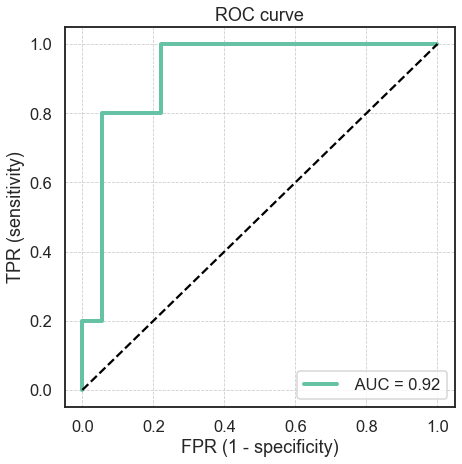

In [162]:
svc_2 = run_SVM(X_train, y_train)

In [163]:
svc_2.score(X_test, y_test)

0.8260869565217391

In [164]:
svc_2.predict(X_test)

array([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [171]:
y_score = svc_2.decision_function(X_test)
y_score

array([-1.72016622, -1.93800141, -0.74354454, -0.79358885, -3.37525838,
       -1.01619051,  0.68982714, -0.16716964,  0.29202902,  0.43628471,
       -1.36717695,  0.7791691 , -2.0850043 , -2.98829744, -1.92062773,
       -0.75874   , -1.7354806 , -2.0583857 ,  0.37287767, -1.34585488,
       -1.6415637 , -1.05600717, -0.43481144])

In [172]:
roc_auc_score( y_true = y_test, y_score = svc_2.decision_function(X_test)) 

1.0

In [58]:
bestSVC.predict(X_test)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0.], dtype=float32)

In [59]:
y_test.to_numpy()

array([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0.], dtype=float32)

In [60]:
y_test_predicted = bestSVC.score(X_test, y_test)
y_test_predicted

0.9565217391304348

In [70]:
#y_test_pred_prob
bestSVC.decision_function(X_DUD)

array([ 0.83669393, -0.55243806, -0.06602759, ..., -0.74873066,
       -1.42002621, -0.02911411])

In [ ]:
y_DUD

In [72]:
# Evaluación con el AUC
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_score( y_true = y_DUD, y_score = bestSVC.decision_function(X_DUD)) 

0.7752665273759778

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, bestSVC.decision_function(X_test))

# ----------------

In [3]:
# Autodock 4. LE (lowest energy)
df_ad4_results_LE = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
# Autodock 4. LC (largest Cluster)
df_ad4_results_LC = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring 16x
df_vinardo_results = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
# vinardo scorings 8x
df_vinardo_results = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_VINARDO_ex8.csv', index_col=0)

## Vinardo

# SVM Lineal con Vinardo 16x

In [230]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

In [413]:
# Primer intento para vinardo a 16x
X = df_vinardo_results.drop(["ActiveInactive"], axis = 1)
y = (df_vinardo_results["ActiveInactive"] == "Active").astype(np.float32)

print(F'Dimensiones de X: {X.shape}')
print(F'Dimensiones de y: {y.shape}')

Dimensiones de X: (111, 402)
Dimensiones de y: (111,)


In [414]:
# Cambio en la versión del dataset X
# best_vinardo_confs = df_cdk2_labels[df_cdk2_labels.AUC_vrd_16x >= 0.68].index
best_vinardo_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf != 'active'].index
X = X[best_vinardo_confs]

print(F'Dimensiones de X: {X.shape}')

Dimensiones de X: (111, 288)


## Pipeline

In [434]:
# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge'))
    ])

parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])
linearSVC = GridSearchCV(SVCpipe, parametros, 
                         scoring = 'roc_auc',
                         cv = 5, return_train_score = True)

# Split del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)


C: [0.01, 0.1, 1, 10, 100, 1000, 10000]


In [429]:
# Entrenamiento con el grid
linearSVC.fit(X_DUD, y_DUD)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to c

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVC',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='hinge', max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
            

In [430]:
# DEfinimos el rango de parámetros para el parámtro C
bestSVC = linearSVC.best_estimator_
bestSVC.score(X_train, y_train)

0.8068181818181818

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [433]:
bestSVC.score(X_test, y_test)

0.782608695652174

In [67]:
# Split de los sets de entrenamiento y prueba
df_vrd_DUD2006 = pd.read_csv(F'./B_DATOS/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
y_DUD = pd.Series(df_vrd_DUD2006.Actividad == "Active", dtype = int)
X_DUD = df_vrd_DUD2006.drop(["Actividad"], axis = 1)

In [68]:
bestSVC.score(X_DUD, y_DUD)

0.9137931034482759

In [69]:
pred = bestSVC.predict(X_DUD)
print("Vinardo 8x:", roc_auc_score( y_true = y_DUD, y_score = pred ))

Vinardo 8x: 0.6805622522232937


In [368]:
# Primer intento para vinardo a 16x
X = df_vinardo_results.drop(["ActiveInactive"], axis = 1)
y = (df_vinardo_results["ActiveInactive"] == "Active").astype(np.float32)

print(F'Dimensiones de X: {X.shape}')
print(F'Dimensiones de y: {y.shape}')

Dimensiones de X: (111, 402)
Dimensiones de y: (111,)


## SVM lineal con las mejores conformaciones
Seleccionamos las conformaciones con un AUC en vinardo mayor a 0.75

In [20]:
best_vinardo_confs = df_cdk2_labels[df_cdk2_labels.AUC_vrd_16x >= 0.8].index
best_vinardo_confs.shape

df = df_vinardo_results[["ActiveInactive"] + best_vinardo_confs] 
X = df.iloc[:, 1:]
y = (df["ActiveInactive"] == "Active").astype(np.float32)
X.shape

KeyError: "None of [Index(['ActiveInactive1h01', 'ActiveInactive1h07', 'ActiveInactive1ke5',\n       'ActiveInactive1ke6', 'ActiveInactive1ogu', 'ActiveInactive1oiq',\n       'ActiveInactive1pxm', 'ActiveInactive1urw', 'ActiveInactive1vyz',\n       'ActiveInactive2btr', 'ActiveInactive2c4g', 'ActiveInactive2c6o',\n       'ActiveInactive2iw6', 'ActiveInactive2iw8', 'ActiveInactive2iw9',\n       'ActiveInactive2r3p', 'ActiveInactive2r64', 'ActiveInactive2vv9',\n       'ActiveInactive3dog', 'ActiveInactive3ig7', 'ActiveInactive3lfn',\n       'ActiveInactive3ns9', 'ActiveInactive3qu0', 'ActiveInactive3r9h',\n       'ActiveInactive3rk9', 'ActiveInactive3s0o', 'ActiveInactive3sqq',\n       'ActiveInactive3unj', 'ActiveInactive3unk', 'ActiveInactive4bzd',\n       'ActiveInactive4cfn', 'ActiveInactive4eor', 'ActiveInactive4fkj',\n       'ActiveInactive4fkq', 'ActiveInactive5if1', 'ActiveInactive5nev',\n       'ActiveInactive6guf'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge', max_iter = 10000))
    ])

parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])

# Grid par CV
linearSVC = GridSearchCV(SVCpipe, parametros, cv = 5, return_train_score = True)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
linearSVC.fit(X_train, y_train)

## Intento con Vina (peor desempeño que vinardo)

In [ ]:
# Primer intento para vinardo
df = df_vina_results
X = df.iloc[:, 1:]
y = (df["ActiveInactive"] == "Active").astype(np.float32)

# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge', max_iter = 10000))
    ])

parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])

# Grid par CV
linearSVC = GridSearchCV(SVCpipe, parametros, cv = 5, return_train_score = True)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
linearSVC.fit(X_train, y_train)

In [ ]:
# Mejor modelo para vina
bestSVC_vina = linearSVC.best_estimator_
# Seleccionamos el mejor modelo
linearSVC.best_params_

In [ ]:
# Entrenando el mejor modelo nuevamente
bestSVC_vina.fit(X_train, y_train)

In [ ]:
# Exactitud Train
bestSVC_vina.score(X_train, y_train)

In [ ]:
# Exactitud Test
bestSVC.score(X_test, y_test)